In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

import warnings
warnings.filterwarnings("ignore")

## Bootstrap the OIS Discount Factor, and Plot the Discount Curve for T $\in$ \[0, 30\]

In [2]:
OIS_df = pd.read_excel('IR Data.xlsx', sheet_name = 'OIS')
OIS_df = OIS_df.iloc[:, 0:3]
# convert the string to float better to compute
OIS_df['Tenor'] = OIS_df['Tenor'].str.replace('y', '')
OIS_df['Tenor'] = OIS_df['Tenor'].str.replace('m', '')
OIS_df['Tenor'] = OIS_df['Tenor'].astype(float)
# convert 6 months to 1 year
OIS_df['Tenor'].iloc[0] = OIS_df['Tenor'].iloc[0] / 12

In [3]:
# def a function to compute OIS discount factor
def OISDF(f, T): 
    DF = (1 / (1 + (1 / 360) * f)) ** (360 * T)
    return DF

In [4]:
OIS_rate = OIS_df['Rate'].values.tolist()
Tenor_lst = OIS_df['Tenor'].values.tolist()

In [5]:
# OIS Discount Factor 6m
DFO_6m = 1 / (0.5 * OIS_rate[0] + 1)

In [6]:
def OIS_DF(df, T):
    # linear interpolation
    last_tenor = Tenor_lst[Tenor_lst.index(T) - 1]
    tenor_gap = list(range(int(last_tenor) + 1, int(T)))
    interpolation_df = np.interp(tenor_gap, [last_tenor, T], [DFO_lst[-1], df])
    # fixed leg
    fixed_leg = (sum(DFO_lst) + df + sum(interpolation_df)) * OIS_rate[Tenor_lst.index(T)]
    # floating leg
    float_leg = 1 - df
    return fixed_leg - float_leg

In [7]:
DFO_lst = []
DFO_lst.append(0)
for i in Tenor_lst[1:]:
    # solve OIS DF
    DFO = brentq(lambda x: OIS_DF(x, i), 0.001, 1)
    # if require linear interpolation
    last_tenor = Tenor_lst[Tenor_lst.index(i) - 1]
    tenor_gap = list(range(int(last_tenor) + 1, int(i)))
    interpolation_df = np.interp(tenor_gap, [last_tenor, i], [DFO_lst[-1], DFO])
    DFO_lst.extend(interpolation_df)
    # append OIS DF into the list
    DFO_lst.append(DFO)

DFO_lst = DFO_lst[1:]
DFO_lst.insert(0, DFO_6m)

In [8]:
DFO_lst2 = []
for i in Tenor_lst:
    DFO_lst2.append(DFO_lst[int(i)])
    
OIS_df['OIS_df'] = DFO_lst2

In [9]:
OIS_df

,Tenor,Product,Rate,OIS_df
0,0.5,OIS,0.00250,0.998752
1,1.0,OIS,0.00300,0.997009
2,2.0,OIS,0.00325,0.993531
3,3.0,OIS,0.00335,0.990015
4,4.0,OIS,0.00350,0.986117
5,5.0,OIS,0.00360,0.982184
6,7.0,OIS,0.00400,0.972406
7,10.0,OIS,0.00450,0.955977
8,15.0,OIS,0.00500,0.927611
9,20.0,OIS,0.00525,0.900076


In [10]:
Tenor_lst2 = list(range(1, 31))
Tenor_lst2.insert(0, 0.5)

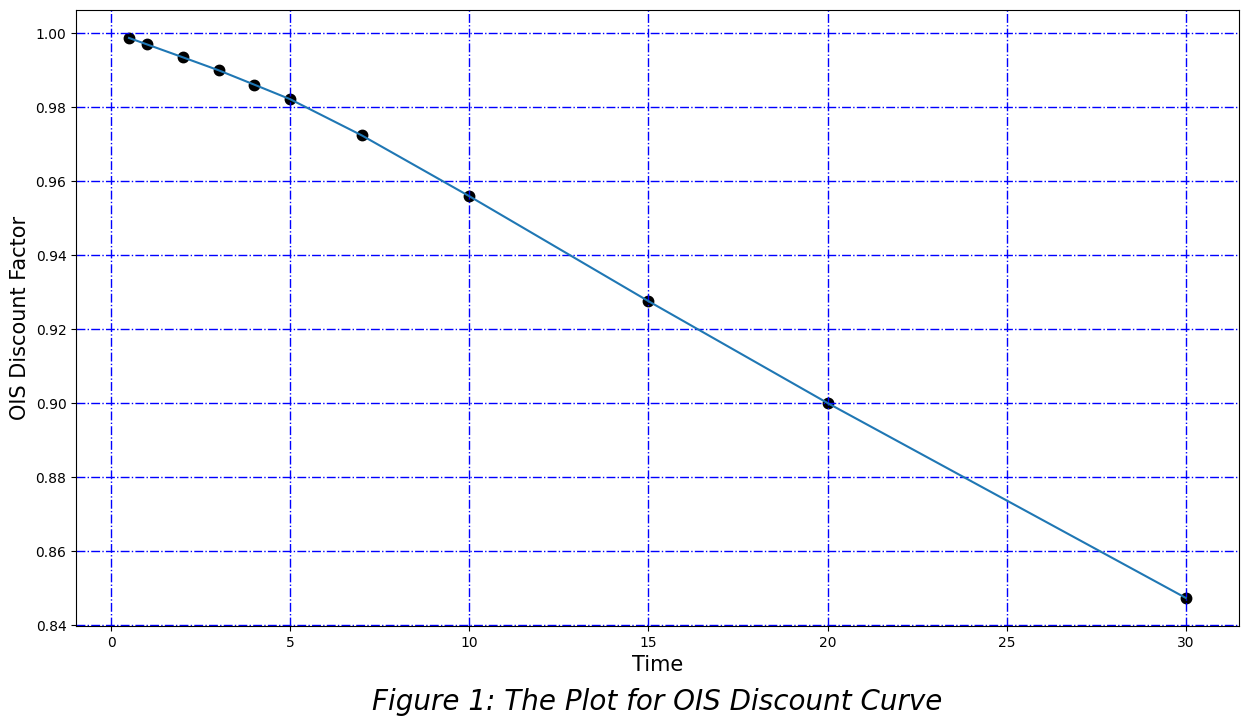

In [11]:
# Plot the Discount Curve
plt.figure(figsize = (15, 8))
plt.plot(Tenor_lst2, DFO_lst)
plt.scatter(Tenor_lst, DFO_lst2, color = 'black', linewidth = 2.5)
plt.grid(color='blue', linewidth = 1, linestyle = '-.')
plt.title(label = "Figure 1: The Plot for OIS Discount Curve", 
         y = -0.15, 
          fontstyle = 'italic', 
         fontsize = 20)
plt.ylabel('OIS Discount Factor', fontsize = 15)
plt.xlabel('Time', fontsize = 15)

plt.savefig("The Plot for OIS Discount Curve.png")

plt.show()

## Bootstrap LIBOR Discount Factor, and Plot it for T $\in$ \[0, 30\]

In [12]:
IRS_df = pd.read_excel('IR Data.xlsx', sheet_name = 'IRS')
IRS_df = IRS_df.iloc[:, 0:3]
IRS_df['Tenor'] = IRS_df['Tenor'].str.replace('y', '')
IRS_df['Tenor'] = IRS_df['Tenor'].str.replace('m', '')
IRS_df['Tenor'] = IRS_df['Tenor'].astype(float)
IRS_df['Tenor'].iloc[0] = IRS_df['Tenor'].iloc[0] / 12

In [13]:
IRS_rate = IRS_df['Rate'].values.tolist()
IRS_tenor = IRS_df['Tenor'].values.tolist()

In [14]:
# LIBOR Discount Factor for 6 month
DF_6m = 1 / (1 + IRS_tenor[0] * IRS_rate[0])

In [15]:
tenor = list(range(1, 61))
IRS_tenor2 = [x / 2 for x in tenor]

In [16]:
OIS_df2 = pd.DataFrame()
OIS_df2['Tenor'] = list(range(0, 31))
OIS_df2['Tenor'].iloc[0] = 0.5
OIS_df2['OIS_DF'] = DFO_lst
OIS_df2.set_index('Tenor', drop=True, inplace=True)

In [17]:
IRS_df2 = pd.DataFrame()
IRS_df2['Tenor'] = IRS_tenor2
IRS_df2.set_index('Tenor', drop=True, inplace=True)
IRS_df2 = pd.concat([IRS_df2, OIS_df2], axis = 1)

In [18]:
IRS_df2.iloc[0] = DFO_6m
IRS_df2['OIS_DF'] = IRS_df2['OIS_DF'].interpolate() # interpolate the necessary discount factor
OIS_DF_lst = IRS_df2['OIS_DF'].tolist()

In [19]:
def LIBOR_df(OIS_DF_lst, LIBOR_DF, T, New_LIBOR_DF):
    freq = 0.5
    # fixed leg
    fixed_leg = IRS_rate[IRS_tenor.index(T)] * freq * sum(OIS_DF_lst[:int(T) * 2])

    # linear interpolation
    last_tenor = IRS_tenor[IRS_tenor.index(T) - 1]
    tenor_gap = list(x / 2 for x in list(range(int(last_tenor*2), int(T*2))))[1:]
    interpolation_df = np.interp(tenor_gap, [last_tenor, T], [LIBOR_DF[-1], New_LIBOR_DF])
    Discount_Factor = LIBOR_DF + list(interpolation_df)
    
    # float leg
    float_leg1 = OIS_DF_lst[0] * IRS_rate[0] * freq
    
    float_leg2 = 0
    for i in range(1, int(2 * T) - 1):
        float_leg2 = float_leg2 + (OIS_DF_lst[i] * ((Discount_Factor[i-1] - Discount_Factor[i]) \
                                 / Discount_Factor[i]))
        
    float_new_leg = OIS_DF_lst[2*int(T)-1] * ((Discount_Factor[-1] - New_LIBOR_DF) / New_LIBOR_DF)
    
    float_leg = float_leg1 + float_leg2 + float_new_leg
    
    return fixed_leg - float_leg

In [20]:
LIBOR_DF = []
LIBOR_DF.append(DF_6m)
for i in IRS_tenor[1:]:
    if i == 1.0: 
        NEW_LIBOR_DF = brentq(lambda x: LIBOR_df(OIS_DF_lst, LIBOR_DF, i, x), 0.001, 1)
        LIBOR_DF.append(NEW_LIBOR_DF)
    else:
        NEW_LIBOR_DF = brentq(lambda x: LIBOR_df(OIS_DF_lst, LIBOR_DF, i, x), 0.001, 1)
        # linear interpolation
        last_tenor = IRS_tenor[IRS_tenor.index(i) - 1]
        tenor_gap = list(x / 2 for x in list(range(int(last_tenor*2), int(i*2))))[1:]
        interpolation_df = np.interp(tenor_gap, [last_tenor, i], [LIBOR_DF[-1], NEW_LIBOR_DF])
        LIBOR_DF.extend(interpolation_df)
        LIBOR_DF.append(NEW_LIBOR_DF)

In [21]:
LIBOR_df2 = pd.DataFrame()
LIBOR_df2['Tenor'] = IRS_tenor2
LIBOR_df2['LIBOR_DF'] = LIBOR_DF
LIBOR_df2.set_index('Tenor', drop=True, inplace=True)

In [22]:
IRS_df2['LIBOR_DF'] = LIBOR_df2['LIBOR_DF']

In [23]:
IRS_df2.to_csv("Discount_Factors.csv")

In [24]:
LIBOR_DF2 = []
for i in IRS_tenor:
    LIBOR_DF2.append(LIBOR_df2.loc[i].values[0])
    
IRS_df['LIBOR_DF'] = LIBOR_DF2
IRS_df.drop(['Product', 'Rate'], axis = 1, inplace=True)

In [25]:
IRS_df

,Tenor,LIBOR_DF
0,0.5,0.987654
1,1.0,0.972577
2,2.0,0.942179
3,3.0,0.910482
4,4.0,0.878981
5,5.0,0.848989
6,7.0,0.784216
7,10.0,0.692710
8,15.0,0.551081
9,20.0,0.408218


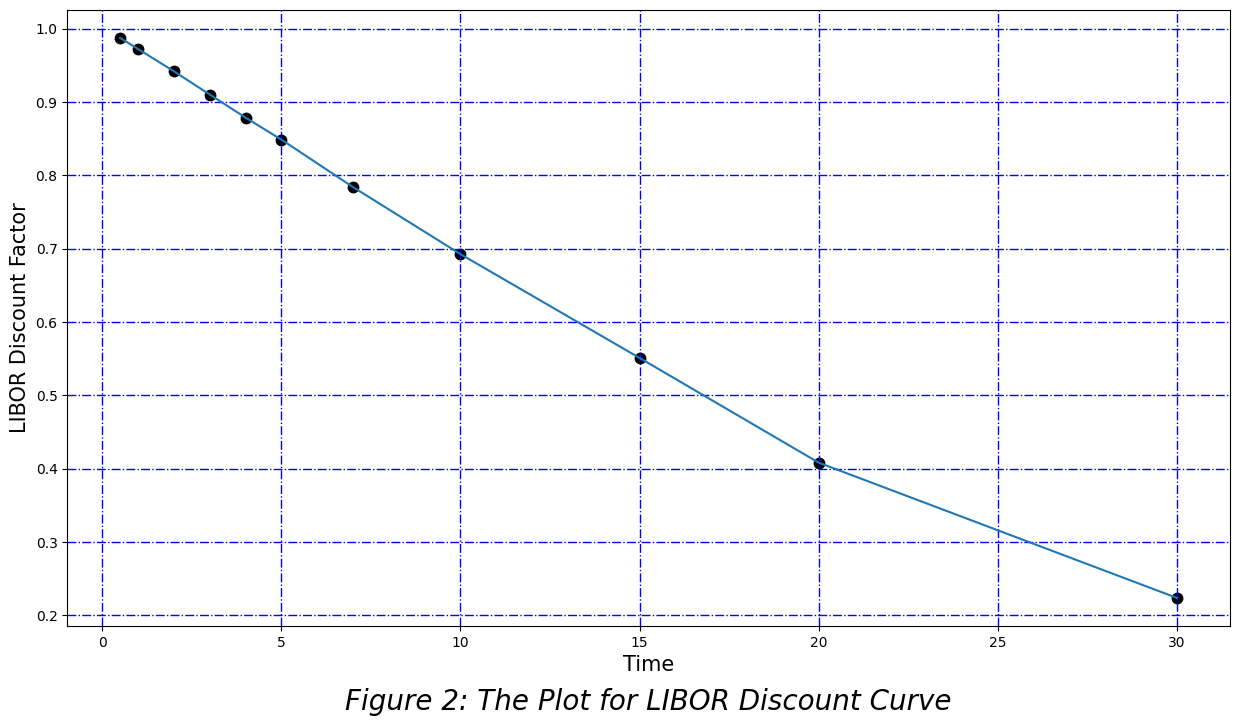

In [26]:
# Plot the Discount Curve
plt.figure(figsize = (15, 8))
plt.plot(IRS_tenor2, LIBOR_DF)
plt.scatter(IRS_tenor, LIBOR_DF2, color = 'black', linewidth = 2.5)
plt.grid(color='blue', linewidth = 1, linestyle = '-.')
plt.title(label = "Figure 2: The Plot for LIBOR Discount Curve", 
         y = -0.15, 
          fontstyle = 'italic', 
         fontsize = 20)
plt.ylabel('LIBOR Discount Factor', fontsize = 15)
plt.xlabel('Time', fontsize = 15)
plt.savefig("The Plot for LIBOR Discount Curve.png")

plt.show()

## Calculate Forward Swap Rate 

In [27]:
def forward_swap_rate(expiry, tenor):
    freq = 0.5
    # fixed leg
    fixed_leg = freq * (IRS_df2.iloc[2*expiry:2*(expiry+tenor), 0].values.sum())
    # floating leg
    float_leg = 0
    for k in range(2 * expiry, 2 * (expiry + tenor)):
        float_leg = float_leg + (IRS_df2.iloc[k, :].values[0] * \
                                ((LIBOR_df2.iloc[k-1, :].values[0] - LIBOR_df2.iloc[k, :].values[0]) / LIBOR_df2.iloc[k, :].values[0]))
    forward_swap_rate = float_leg / fixed_leg
    return forward_swap_rate

In [28]:
tenor_lst = [1, 2, 3, 5, 10]
y1_list = []
for i in tenor_lst:
    y1_list.append(forward_swap_rate(1, i))
    
y5_list = []
for i in tenor_lst:
    y5_list.append(forward_swap_rate(5, i))
    
y10_list = []
for i in tenor_lst:
    y10_list.append(forward_swap_rate(10, i))

In [29]:
swap_rate_df = pd.DataFrame()
swap_rate_df['tenor'] = ['1Y', '2Y', '3Y', '5Y', '10Y']
swap_rate_df['1Y'] = y1_list
swap_rate_df['5Y'] = y5_list
swap_rate_df['10Y'] = y10_list
swap_rate_df.set_index('tenor', drop=True, inplace=True)
swap_rate_df

,1Y,5Y,10Y
tenor,,,
1Y,0.032007,0.039274,0.042189
2Y,0.033259,0.040075,0.043116
3Y,0.034011,0.040072,0.044097
5Y,0.035255,0.041093,0.046249
10Y,0.038428,0.043634,0.053458


In [30]:
swap_rate_df.to_csv('forward_swap_rate.csv')

In [31]:
swap_rate_lst = []
swap_rate_lst.extend(y1_list)
swap_rate_lst.extend(y5_list)
swap_rate_lst.extend(y10_list)

swap_rate_df2 = pd.DataFrame({'Forward_Swap_Rate': swap_rate_lst})
swap_rate_df2.to_csv('forward_swap_rate2.csv')